# Hall strip

**Background**

Motion in a rotating frame can be decomposed into a fast 'cyclotron' coordinate motion and a slower motion of the centers (X,Y) of cyclotron motion. It can be shown that X and Y do not commute, even though absolute spatial coordinates commute. As a result, a force generates motion in a perpendicular direction (the Hall effect). As a special case, a saddle potential enacts a squeezing operator on (X, Y), resulting in the exponential growth and decay of orthogonal sizes of a collection of particles. Since a BEC rotating sufficiently fast in an elliptical trap experiences a saddle potential in the rotating frame, this results in the extension of the cloud into a long strip. The strip has an unbounded length and a minimum width defined by the zero-point cyclotron motion of the bosons.

For more, see https://arxiv.org/abs/1911.12347


In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from tqdm.notebook import tqdm
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
import time
import h5py
import pandas as pd
from condensate import Wavefunction, Environment, hbar
%matplotlib inline

## Prepare groundstate

In [3]:
omega   = 2*np.pi*10
epsilon = 0.4
dt = 1e-5
fov = 300e-6

e = Environment(DIM=512, fov=fov, N=1e6)
e.harmonic_potential(omega=omega, epsilon=epsilon)


            Running condensate on 512x512 grid with:
            atom number: 1e+06 
            mass:        3.80e-26
        


In [3]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=3e8, dt=dt, steps=4000)

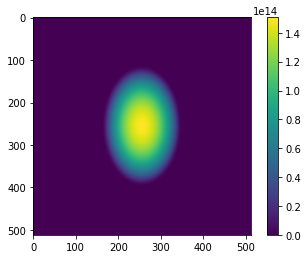

In [4]:
groundstate.show_density()

## Spin up

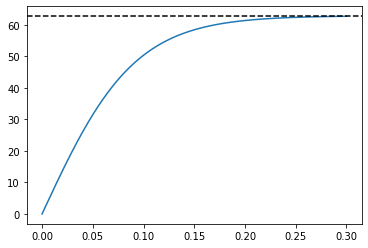

In [61]:
whirrMax = omega
steps = 30000
whirrtime = 30000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]

plt.plot(dt*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()

In [62]:
hallstrip = deepcopy(groundstate)

In [63]:
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0)

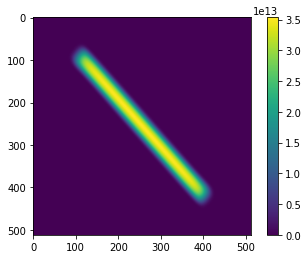

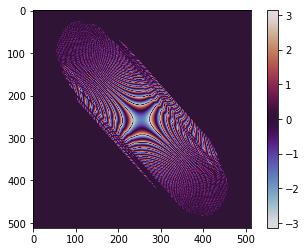

In [64]:
hallstrip.show_density()
hallstrip.show_phase()

In [16]:
widestrip = deepcopy(hallstrip)

In [23]:
def geometric_squeezing(stripPsi, steps=60000, frames=300, datafile='data/geometricsqueezing.hdf5'):
    steps = frames*(steps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    Omega = omega* np.ones(runtime)
    dt = 1e-5
    psi = copy(stripPsi)
    psi.env.rotating_frame(omegaR=Omega)
    out = []
    density = psi.density
    density *= density>1
    out.append(density)
    
    for i in tqdm(range(frames), leave=False):
        psi.evolve(dt=dt, steps=runtime, cooling=0.0)
        density = psi.density
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"geosqueeze"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

In [24]:
geometric_squeezing(widestrip)

## Process Data

In [5]:
# Set some processing parameters
viewx = 350
viewy = 350
fov = 300e-6
dx = fov/512
mass = 3.8e-26
lb = np.sqrt(hbar / (2*mass *omega))
x  = dx * (np.arange(viewx) - viewx//2)
y  = dx * (np.arange(viewy) - viewy//2)
dt = 1e-5
times = np.arange(51)*dt*5e3


def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped

def find_angle(ncrop):
    xsize = len(ncrop)
    xx = np.linspace(-10, 10, xsize)
    yy = np.linspace(-10, 10, xsize)
    xx, yy = np.meshgrid(xx, yy)

    # Calculate the moment of inertia tensor
    Ixx = np.sum(ncrop*yy*yy)
    Iyy = np.sum(ncrop*xx*xx)
    Ixy = np.sum(ncrop*xx*yy)
    Iyx = Ixy
    I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
    evals, evecs = np.linalg.eig(I)
    iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)
    return iangle

    
def process_r1d(dset):
    """ Process a dataset corresponding to a single squeeze time """
    clouds = np.array([rotate_crop(a, viewx, viewy, 42) for a in dset[()]])
    times = np.array(dset.attrs['time'])
    xprofile  =  np.sum(rotate_crop(clouds[0],viewy=150), axis=0)
    xprofilemax = np.max(xprofile)
    gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
    newresults = pd.DataFrame([[clouds, times, xprofile, gaussfit]],
                              columns=columns)
    return newresults




In [6]:
columns = ['cloud', 'time', 'xprofile', 'gaussfit']
gs = pd.DataFrame(columns=columns)

with h5py.File('data/geometricsqueezing.hdf5', 'r') as f:
    for name in tqdm(f):
        dset=f[name]
        alltimes =  np.array(dset.attrs['time'])
        for i in tqdm(range(len(dset)-1), leave=False):
            cloud = rotate_crop(np.fliplr(dset[i]), viewx, viewy, 42.2)
            xprofile  =  np.sum(rotate_crop(cloud, viewx=350, viewy=150), axis=0)
            xprofilemax = np.max(xprofile)
            gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
            newresults = pd.DataFrame([[cloud, alltimes[i], xprofile, gaussfit]], columns=columns)
            gs = gs.append(newresults)
            
        
        
    

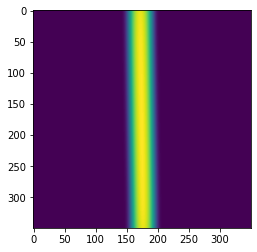

In [7]:
plt.imshow(gs.iloc[0].cloud)

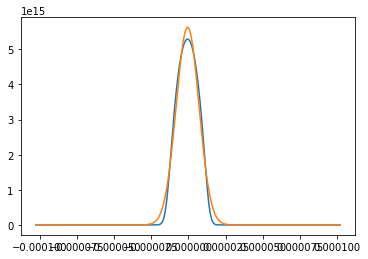

In [8]:
plt.plot(x,gs.iloc[0].xprofile)
plt.plot(x,gauss(x,*gs.iloc[0].gaussfit))

In [9]:
gs.head()

,cloud,time,xprofile,gaussfit
0,"[[-3.9280891945311203e-72, 2.5710618938559518e...",0.000,"[-1.7924267791136416e-64, 1.1600367318652414e-...","[-5.377130092856117e-07, 5631059702321920.0, 7..."
0,"[[-5.608919734916519e-75, 3.662526296899015e-7...",0.002,"[-1.1383302517250571e-65, 8.233918801649875e-6...","[-5.768801071276983e-07, 5632201043031299.0, 7..."
0,"[[-2.3188303359023972e-74, 1.5175255991022012e...",0.004,"[2.859403516086505e-67, -2.9030216237582063e-6...","[-5.858407453417032e-07, 5600297104034290.0, 7..."
0,"[[2.163255777143562e-76, -1.4156886795161404e-...",0.006,"[2.0444656757985464e-67, -8.163499235378625e-6...","[-5.608631010926248e-07, 5522865742771310.0, 7..."
0,"[[7.200605548652779e-78, -4.712303890162479e-7...",0.008,"[8.24467823377256e-69, -2.7942379645899435e-68...","[-5.038785694519728e-07, 5395735558365322.0, 7..."


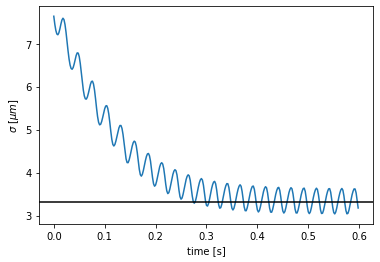

In [12]:

widths = np.array([abs(r[4][2]) for r in gs.itertuples()])
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
plt.savefig('figures/rotini1d/widths.png')


In [22]:
zeta = epsilon * omega / 2

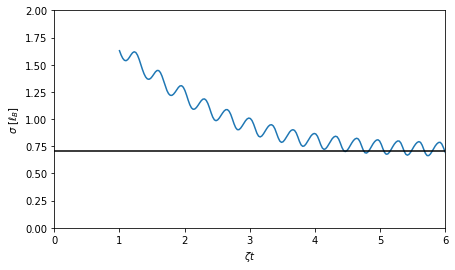

In [37]:
plt.figure(figsize=(7,4))
widths = np.array([1e-6 * abs(r[4][2]) / lb for r in gs.itertuples()])
plt.plot(zeta * gs['time'] +1, 1e6*widths)
plt.axhline(1/np.sqrt(2),c='k')
plt.xlabel(r'$\zeta t$')
plt.ylabel(r'$\sigma$ [$\ell_B$]')
plt.ylim([0,2])
plt.xlim([0,6])
plt.savefig('figures/rotini1d/widths.png', dpi=200)

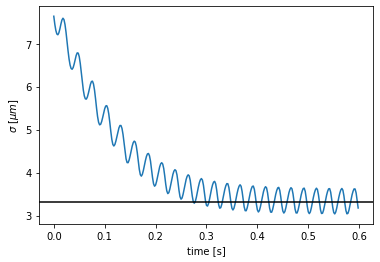

In [10]:
widths = np.array([abs(r[4][2]) for r in gs.itertuples()])
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
plt.savefig('figures/rotini1d/widths.png')


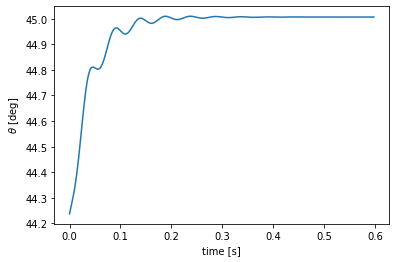

In [60]:
angles = []
for i,r in gs.iterrows():
    angles.append(find_angle(r.cloud))
    
plt.plot(gs['time'], -44.97+np.array(angles))
# plt.axhline(90,c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\theta$ [deg]')
plt.savefig('figures/rotini1d/angles.png')

# Reproducing lab parameters


            Running condensate on 512x512 grid with:
            atom number: 8e+05 
            mass:        3.80e-26
        


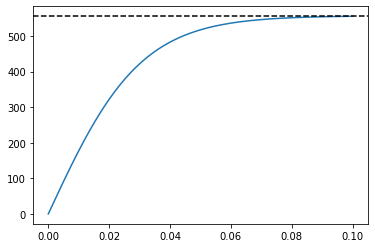

In [2]:
omega   = 2*np.pi*88.6
epsilon = 0.2
dt = 1e-6

e = Environment(DIM=512, fov=120e-6, N=8e5)
e.harmonic_potential(omega=omega, epsilon=epsilon)

groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=1e9, dt=2*dt, steps=4000)
groundstate.evolve(dt=dt, cooling=0.01, steps=4000)

whirrMax = omega
steps = 100000
whirrtime = 100000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]
plt.plot(dt*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()


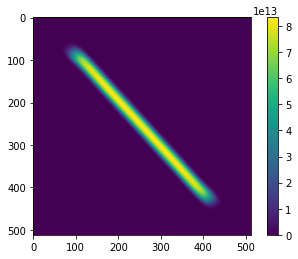

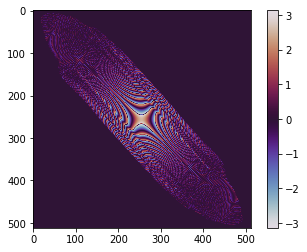

In [3]:
# Run the sim - takes longer than the 10Hz sim above
hallstrip = deepcopy(groundstate)
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0)
hallstrip.show_density()
hallstrip.show_phase()

In [4]:
finalstrip = deepcopy(hallstrip)

## Crop and find the angle to the diagonal after the ramp

In [10]:
width = 512//2
plotrange=140
ncrop = finalstrip.density[(width-plotrange):(width+plotrange),(width-plotrange):(width+plotrange)]

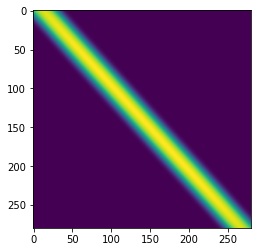

In [13]:
plt.imshow(ncrop)

In [20]:
xsize = len(ncrop)
xx = np.linspace(-10, 10, xsize)
yy = np.linspace(-10, 10, xsize)
xx, yy = np.meshgrid(xx, yy)

# Calculate the moment of inertia tensor
Ixx = np.sum(ncrop*yy*yy)
Iyy = np.sum(ncrop*xx*xx)
Ixy = np.sum(ncrop*xx*yy)
Iyx = Ixy
I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
evals, evecs = np.linalg.eig(I)
iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)


In [21]:
print(f"angle from diagonal equipotential: {(iangle-45):.2f} degrees")

angle from diagonal equipotential: 2.47 degrees
